# Bag of N grams tutorial

N-gram can be defined as the contiguous sequence of n items from a given sample of text or speech. The items can be letters, words, or base pairs according to the application. The N-grams typically are collected from a text or speech corpus (A long text dataset).

For instance, N-grams can be unigrams like (“This”, “article”, “is”, “on”, “NLP”) or bigrams (“This article”, “article is”, “is on”, “on NLP”).

In [6]:
from sklearn.feature_extraction.text import CountVectorizer


In [9]:
v = CountVectorizer()
v.fit(["Iron man is richest man"])
v.vocabulary_

{'iron': 0, 'man': 2, 'is': 1, 'richest': 3}

In [12]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(["Iron man is richest man"])
v.vocabulary_

{'iron': 0,
 'man': 4,
 'is': 2,
 'richest': 6,
 'iron man': 1,
 'man is': 5,
 'is richest': 3,
 'richest man': 7}

In [13]:
v = CountVectorizer(ngram_range=(1,3))
v.fit(["Iron man is richest man"])
v.vocabulary_

{'iron': 0,
 'man': 6,
 'is': 3,
 'richest': 9,
 'iron man': 1,
 'man is': 7,
 'is richest': 4,
 'richest man': 10,
 'iron man is': 2,
 'man is richest': 8,
 'is richest man': 5}

In [14]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [17]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocessing(text):
    doc=nlp(text)
    filtered_token=[]
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_token.append(token.lemma_)
    return " ".join(filtered_token)

In [18]:
preprocessing("Thor ate pizza")

'thor eat pizza'

In [19]:
preprocessing("Loki is eating pizza")

'Loki eat pizza'

In [21]:
corpus_processed = [
    preprocessing(text) for text in corpus
]
corpus_processed

['thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [22]:

v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

### News Category Classification Problem
Okay now that we know basics of BAG of n grams vectorizer 😎 It is the time to work on a real problem. Here we want to do a news category classification. We will use bag of n-grams and traing a machine learning model that can categorize any news into one of the following categories,

BUSINESS
SPORTS
CRIME
SCIENCE

In [23]:
import pandas as pd

In [26]:
df = pd.read_json("news_dataset.json")
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [27]:
df.category.value_counts()

BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64

Imbalance dataset , so now for learning will make all categories as per min value

In [28]:
min_samples = 1381 # we have these many SCIENCE articles and SCIENCE is our minority class


df_business = df[df.category=="BUSINESS"].sample(min_samples, random_state=2022)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=2022)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=2022)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=2022)

In [29]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()

BUSINESS    1381
SPORTS      1381
CRIME       1381
SCIENCE     1381
Name: category, dtype: int64

#### Convert text category to a number

In [30]:
target = {'BUSINESS': 0, 'SPORTS': 1, 'CRIME': 2, 'SCIENCE': 3}

df_balanced['category_num'] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1, 
    'CRIME': 2, 
    'SCIENCE': 3
})

In [31]:
df_balanced.head()

,text,category,category_num
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0
502,How to Market Your Business While Traveling th...,BUSINESS,0
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0


#### Build a model with original text (no pre processing)

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
)

In [34]:
X_train.shape

(4419,)

In [35]:
X_test.shape

(1105,)

In [36]:
y_train.value_counts()


3    1105
2    1105
0    1105
1    1104
Name: category_num, dtype: int64

In [37]:
y_test.value_counts()

1    277
0    276
3    276
2    276
Name: category_num, dtype: int64

##### Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model



In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.87      0.81       276
           1       0.93      0.80      0.86       277
           2       0.83      0.90      0.86       276
           3       0.90      0.80      0.85       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



In [39]:
X_test[:5]

3716     African Nation Slaps Exxon With Fine Nearly 7 ...
608      These Cringe-Worthy Stories Show It Can Be Har...
11172    LISTEN: The Accidental Discovery That Proved T...
1346     Build Loyalty -- The Cost -- $00.00 Remember y...
1356     Man Killed By Michigan Police Wasn't Targeting...
Name: text, dtype: object

In [40]:
y_pred[:5]

array([0, 3, 3, 0, 2], dtype=int64)

##### Attempt 2 : Use 1-gram and bigrams

In [41]:
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       276
           1       0.95      0.74      0.83       277
           2       0.82      0.88      0.85       276
           3       0.92      0.78      0.84       276

    accuracy                           0.82      1105
   macro avg       0.85      0.82      0.83      1105
weighted avg       0.85      0.82      0.83      1105



##### Attempt 2 : Use 2-gram and bigrams

In [42]:
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 3))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       276
           1       0.96      0.73      0.83       277
           2       0.83      0.87      0.85       276
           3       0.93      0.76      0.83       276

    accuracy                           0.82      1105
   macro avg       0.84      0.82      0.82      1105
weighted avg       0.84      0.82      0.82      1105



### Using text pre-processing to remove stop words, punctuations and apply lemmatization

In [44]:
df_balanced['preprocessed_txt'] = df_balanced['text'].apply(preprocessing) 

In [45]:
df_balanced

,text,category,category_num,preprocessed_txt
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0,GCC Business leader remain confident Face Regi...
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0,Honest Review Employees wake morning love impo...
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0,Mike McDerment CEO FreshBooks Talks give build...
502,How to Market Your Business While Traveling th...,BUSINESS,0,market business travel World recently amazing ...
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0,leverage intuition decision making feel safe r...
...,...,...,...,...
2178,Aquarium To Monitor Animals' Behavior Changes ...,SCIENCE,3,aquarium Monitor Animals Behavior Changes Ecli...
5682,How Google Glass Could Save Lives In The Hospi...,SCIENCE,3,Google Glass save life Hospital ER new study h...
1643,Honda's Gravity Modification Research For us A...,SCIENCE,3,Honda Gravity Modification Research Americans ...
11428,EVERYONE Loves Alternative Facts THE POWER OF ...,SCIENCE,3,love Alternative Facts power story 21st centur...


In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    
    df_balanced.preprocessed_txt, 
    df_balanced.category_num, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df_balanced.category_num
    
)

In [47]:
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
    ('Multi NB', MultinomialNB())
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       276
           1       0.94      0.82      0.87       277
           2       0.82      0.91      0.86       276
           3       0.91      0.82      0.86       276

    accuracy                           0.86      1105
   macro avg       0.86      0.86      0.86      1105
weighted avg       0.86      0.86      0.86      1105



In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[242,   7,  16,  11],
       [ 12, 226,  33,   6],
       [ 17,   2, 252,   5],
       [ 37,   6,   7, 226]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

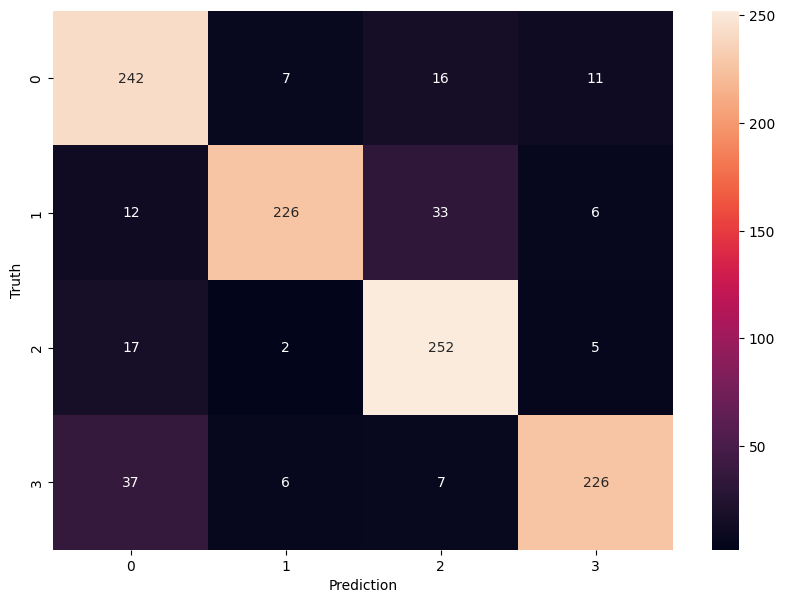

In [49]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')